<h1 style="font-size: 30px; color:orange;">Generative Adversarial Network (GAN) on the MNIST-Dataset using Tensorflow</h1>
<h2 style="font-size: 20px;">Authors: Bruno Figura & Daniel Labuda, ML II Projektarbeit Gruppe 2, SoSe24</h2>
-----------------------------------------------------------------------------------------------------


In [1]:
#Import all necessary libraries. Libraries can be found in the requirements.txt
import os
import sys
import PIL
import time
import glob
import imageio
import numpy as np
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.stats import entropy

import keras
import tensorflow as tf
from keras.models import Model
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Print Python environment information
print(sys.prefix, sys.version, "\n")

# Ensure the relevant folders exist
if not os.path.exists('MNIST_gif'):
    os.makedirs('MNIST_gif')

if not os.path.exists('MNIST_backups'):
    os.makedirs('MNIST_backups')

c:\Users\labud\.conda\envs\ML2_env 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)] 



In [9]:
# Ensure TensorFlow is set up to use the GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("List of GPUs:",gpus)
if gpus:
    print("GPU is available and will be used for generation.")
    device_name = '/GPU:0'
    print("CUDA Support:", tf.test.is_built_with_cuda())
else:
    print("GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.")
    device_name = '/CPU:0'

List of GPUs: []
GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.


Import & prep dataset

Training data shape:
 (60000, 28, 28, 1) 

Test data shape:
 (10000, 28, 28, 1) 

Training labels shape:
 (60000, 10) 

Test labels shape:
 (10000, 10)


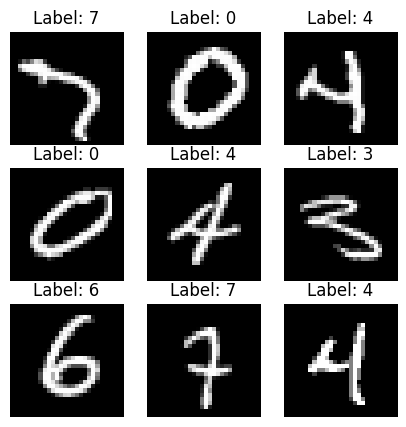

In [10]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")
 
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
 
train_data = (train_data - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_data = (test_data - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_digits = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i], cmap='gray')
    plt.title(f"Label: {np.argmax(train_labels[random_indices[i]])}")
    plt.axis('off')
plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_14 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_17 (Ba  (None, 14, 14, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 14, 14, 128)      

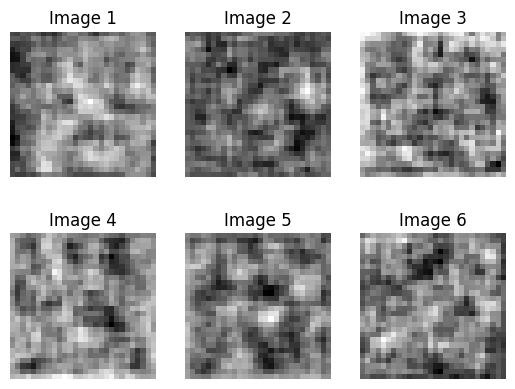

In [11]:
#Source for generator and discriminator models (DCGAN): https://doi.org/10.1007/s11042-019-08600-2
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(128 * 7 * 7, activation="relu", input_shape=(100,)))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.Conv2D(1, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))

    return model

generator = make_generator_model()
generator.summary()
print("\n\n\n")

#plt.suptitle("Generated Images", fontsize=14)  
for i in range(6):
    noise = tf.random.normal([1, 100])
    generator = make_generator_model()
    generated_image = generator(noise, training=False)

    plt.subplot(2, 3, i+1)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
#plt.tight_layout()
plt.show()

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[28, 28, 1], padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print("\n\n\n")
print (decision)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 8, 8, 64)          0         
 ing2D)                                                          
                                                                 
 batch_normalization_31 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                   

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)


noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    generator_losses = []
    discriminator_losses = []


    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch + 1}/{epochs}')

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_losses.append(gen_loss)
            discriminator_losses.append(disc_loss)

        # Produce images and plot losses at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        plot_loss(generator_losses, discriminator_losses, epoch + 1)
        print('Time for epoch {} is {:.1f} sec'.format(epoch + 1, time.time()-start))

    # Generate and plot images after the final epoch 
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    plot_loss(generator_losses, discriminator_losses, epochs)
    #plot_accuracy(accuracy_rates)

    print('Generator loss after {} epochs: {:.2f}'.format(epoch+1, gen_loss))
    print('Discriminator loss after {} epochs: {:.2f}'.format(epoch+1, disc_loss))
    #print('Accuracy Rate after {} epochs: {:.2f}'.format(epoch+1, accuracy_rate))
    
def plot_loss(generator_losses, discriminator_losses, epoch):
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Generator and Discriminator Losses')
    plt.legend()
    plt.savefig('losses_gan_mnist.svg', format='svg', bbox_inches='tight')
    plt.show()
  
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 256, cmap='gray')
        plt.axis('off')

    plt.savefig('MNIST_gif/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

This cell runs the training of the GAN

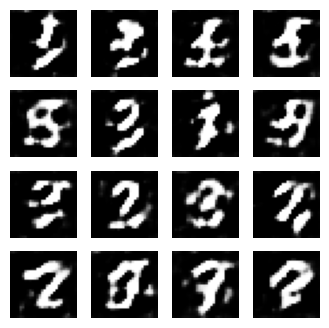

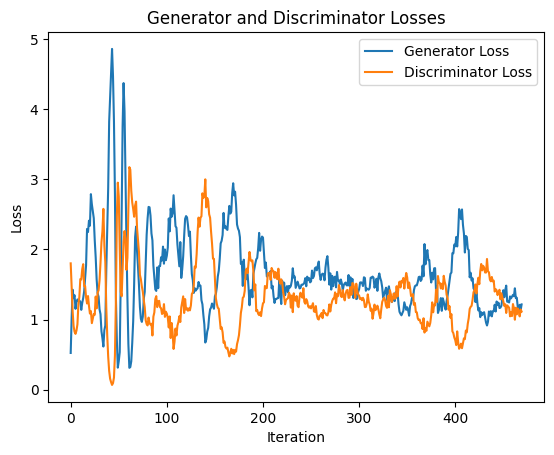

Generator loss after 2 epochs: 1.22
Discriminator loss after 2 epochs: 1.11


In [14]:
EPOCHS = 100

train(train_dataset, EPOCHS)

# Backup the generator and discriminator models
generator.save('MNIST_backups/MNIST_generator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
discriminator.save('MNIST_backups/MNIST_discriminator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

# Save the generator model for further processing
generator.save('MNIST_generator_model_{}epochs.keras'.format(EPOCHS))

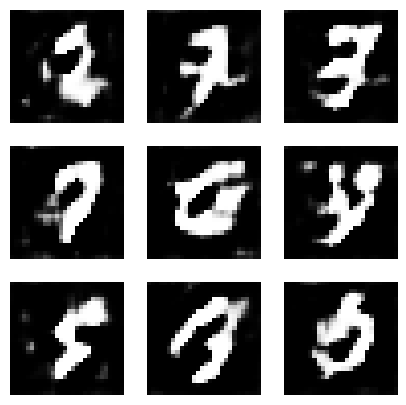

In [14]:
#Load generator from folder
generator = tf.keras.models.load_model('MNIST_generator_model_2epochs.keras')

# Define the number of new MNIST digits to generate
n = 50  # You can change this number as needed

# Generate images noise
random_noise = tf.random.normal([n, noise_dim])
generated_images = generator(random_noise, training=False)

# Rescale the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0
generated_images = generated_images.numpy()

random_indices = np.random.choice(generated_images.shape[0], 9, replace=False)
random_digits = generated_images[random_indices]

# Plot the random images
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


In [15]:
# Function to calculate accuracy and error rate
def calculate_accuracy_rate(generator, discriminator, num_samples=10000):
    # Generate a batch of real and fake images
    real_images = train_data[:num_samples]
    noise = tf.random.normal([num_samples, noise_dim])
    fake_images = generator(noise, training=False)

    # Get discriminator predictions
    real_predictions = discriminator(real_images, training=False)
    fake_predictions = discriminator(fake_images, training=False)

    # Calculate accuracy and error rate
    real_labels = tf.ones_like(real_predictions)
    fake_labels = tf.zeros_like(fake_predictions)

    real_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_predictions), real_labels), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_predictions), fake_labels), tf.float32))

    accuracy_rate = (real_accuracy + fake_accuracy) / 2.0

    return accuracy_rate.numpy()

# Calculate accuracy rate and error rate
accuracy_rate = calculate_accuracy_rate(generator, discriminator)

print(f"Accuracy Rate: {accuracy_rate:.4f}")



Accuracy Rate: 0.5002
